In [ ]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pmlb as dsets
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd
from numpy import array as arr

# sklearn models
sys.path.append('../scores')
import scores
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import interactions
from scipy import interpolate

In [30]:
data_dir = '/scratch/users/vision/data/pmlb'
out_dir = '/scratch/users/vision/chandan/pmlb'
dset_names = deepcopy(dsets.classification_dataset_names)
dset_names.remove('kddcup') # # remove biggest dset
dset_names.remove('mnist') # # remove biggest dset
dset_names.remove('poker') # # remove biggest dset

dset_names = np.array(dset_names)
random_state = 42 # for each train_test_split

# train models
this code will save all the **classification** dsets and fit very quick models to each of them

In [ ]:
from train import fit_logit_and_rfs
fit_logit_and_rfs(dset_names, data_dir, out_dir, random_state=random_state)

# analyze results

In [37]:
results = pd.DataFrame(pkl.load(open(oj(out_dir, 'classification_results_orig_seeded.pkl'), 'rb')))

# plot
# sns.boxplot(data=[results['logit_test_score'], results['rf_test_score']])
# plt.xticks([0, 1], ['Logistic Regression', 'Random Forest'])
# plt.ylabel('Test Accuracy')
# plt.show()

# singlevar logistic vs logistic of curve

In [4]:
from single_var_funcs import *
# calc_single_var_scores(results, data_dir, out_dir, random_state, add_feature=True, all_features=False)
# has keys dset_name, logit_test_score, rf_test_score

# load all scores results

In [5]:
# full_results_162
# full_results_71_add_feature.pkl
full_results = pd.DataFrame(pkl.load(open(oj(out_dir, 'full_results_71_add_feature.pkl'), 'rb')))

In [58]:
r = results
print('results shape', r.shape)


score_results = {
        'feature_scores_mdi': [],
#         'feature_scores_mda': [],
        'logit_score_orig_onevar': [],
        'logit_score_altered_onevar': [],
        'logit_score_altered_append': [],    
        'variances': [],
        'logit_score_altered_interaction_onevar': [],    
        'logit_score_altered_interaction_append': [],
    }

for dset_num in tqdm(range(results.shape[0])): #tqdm(range(2)): #range(r.shape[0]):

    # load data and rf
    row = r.iloc[dset_num]    
    dset_name = row.dset_name # results['dset_names'][idx_0] #dsets.classification_dataset_names[0]
    X, y = dsets.fetch_data(dset_name, return_X_y=True, 
                      local_cache_dir=data_dir)
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=random_state)
    num_features = X.shape[1]
    rf = row.rf
    assert(rf.score(test_X, test_y) == row.rf_test_score) # check that acc matches

    
    # feature importances
    feature_scores_mdi = scores.get_importance_scores(rf, score_type='mdi', X=test_X, Y=test_y)
    score_results['feature_scores_mdi'].append(feature_scores_mdi)
    # feature_scores_mda = scores.get_importance_scores(rf, score_type='mda', X=test_X, Y=test_y)
    # score_results['feature_scores_mda'].append(feature_scores_mda)

    
    # get importance for 1d var
    feat_num = np.argsort(feature_scores_mdi)[-1]
    feat_vals = X[:, feat_num].reshape(-1, 1)
    feat_vals_train = train_X[:, feat_num].reshape(-1, 1)
    feat_vals_test = test_X[:, feat_num].reshape(-1, 1)
    feat_val_min = np.min(feat_vals)
    feat_val_max = np.max(feat_vals)

    # appropriate variable to get importance for
    S = np.zeros(num_features)
    S[feat_num]= 1

#     x_axis, scores_on_spaced_line = single_var_grid_scores_and_plot(rf, train_X, train_y, S, (feat_val_min, feat_val_max), plot=False)
#     f = interpolate.interp1d(x_axis, scores_on_spaced_line, kind='nearest') # function to interpolate the scores
    X_alt_train = interactions.interactions_forest(forest=rf, input_space_x=train_X, outcome_space_y=train_y, 
                                             assignment=train_X, S=S, continuous_y=False).reshape(-1, 1)
    X_alt_test = interactions.interactions_forest(forest=rf, input_space_x=train_X, outcome_space_y=train_y, 
                                             assignment=test_X, S=S, continuous_y=False).reshape(-1, 1)

    

    # fit only on one feature orig
    logit = LogisticRegression(solver='liblinear', multi_class='auto', random_state=random_state) # liblinear best for small dsets, otherwise lbfgs
    logit.fit(feat_vals_train, train_y)
    score_results['logit_score_orig_onevar'].append(logit.score(feat_vals_test, test_y))
    
    # fit only on one feature altered
    logit = LogisticRegression(solver='liblinear', multi_class='auto', random_state=random_state) # liblinear best for small dsets, otherwise lbfgs
    logit.fit(X_alt_train, train_y)
    score_results['logit_score_altered_onevar'].append(logit.score(X_alt_test, test_y))

    # fit with altered feature (appended)
    logit = LogisticRegression(solver='liblinear', multi_class='auto', random_state=random_state) # liblinear best for small dsets, otherwise lbfgs
    logit.fit(np.hstack((train_X, X_alt_train)), train_y)
    score_results['logit_score_altered_append'].append(logit.score(np.hstack((X_test, X_alt_test)), test_y))    
    
    # fit with 2D interaction (using feat_num and some other variable)
    variances = np.zeros(num_features) # variance of max feature with other features
    for i in range(num_features):
        if not i == feat_num:
            S = np.zeros(num_features)
            S[feat_num]= 1
            S[i] = 1
        variances[i] = interactions.variance2D(forest=rf, X=train_X, y=train_y, S=S, 
                                               intervals='auto', dis='auto', continuous_y=False)
    score_results['variances'].append(variances)
    
    # for feat with max interaction with the original max feat (chosen with mdi), refit using the interaction
    feat_num_2 = np.argmax(variances)
    S = np.zeros(num_features)
    S[feat_num]= 1
    S[feat_num_2] = 1

    X_interaction_train = interactions.interactions_forest(forest=rf, input_space_x=train_X, outcome_space_y=train_y, 
                                             assignment=train_X, S=S, continuous_y=False)
    X_interaction_test = interactions.interactions_forest(forest=rf, input_space_x=train_X, outcome_space_y=train_y, 
                                             assignment=test_X, S=S, continuous_y=False)
    
    
    # fit only on one interaction altered
    logit = LogisticRegression(solver='liblinear', multi_class='auto', random_state=random_state) # liblinear best for small dsets, otherwise lbfgs
    logit.fit(X_interaction_train, train_y)
    score_results['logit_score_altered_interaction_onevar'].append(logit.score(X_interaction_test, test_y))
    
     # fit with altered interaction (appended)
    logit = LogisticRegression(solver='liblinear', multi_class='auto', random_state=random_state) # liblinear best for small dsets, otherwise lbfgs
    logit.fit(np.hstack((train_X, X_interaction_train)), train_y)
    score_results['logit_score_altered_interaction_append'].append(logit.score(np.hstack((X_test, X_interaction_test)), test_y))    
    
    
    # saving
    scores_df = pd.DataFrame(score_results)
    full_results = pd.concat([results.iloc[list(range(dset_num + 1))], scores_df], axis=1)
    out_str = f'full_results_{dset_num}_full'
    pkl.dump(full_results, open(oj(out_dir, out_str + '.pkl'), 'wb'))











  0%|          | 0/163 [00:00<?, ?it/s]

results shape (163, 4)


NameError: name 'X_train' is not defined

In [6]:
mean_scores = []
orig_mean = []
alt_mean = []
orig_top = []
alt_top = []
orig_top_mda = []
alt_top_mda = []
for i in range(full_results.shape[0]):
    row = full_results.iloc[i]
    orig = arr(row.logit_score_orig_onevar_list)
    alt = arr(row.logit_score_altered_onevar_list)
#     plt.hist(alt - orig)
    mean_scores.append(np.mean(alt - orig))
    orig_mean.append(np.mean(orig))
    alt_mean.append(np.mean(alt))     
    
    if orig.size > 1:
        feat_ranks = np.argsort(row.feature_scores_mdi)
        max_feat = feat_ranks[-1]
        orig_top.append(row.logit_score_orig_onevar_list[max_feat])
        alt_top.append(row.logit_score_altered_onevar_list[max_feat])

        feat_ranks = np.argsort(row.feature_scores_mda)
        max_feat = feat_ranks[-1]
        orig_top_mda.append(row.logit_score_orig_onevar_list[max_feat])
        alt_top_mda.append(row.logit_score_altered_onevar_list[max_feat])    

  
        
orig_top_mda = arr(orig_top_mda)
alt_top_mda = arr(alt_top_mda)
orig_top = arr(orig_top)
alt_top = arr(alt_top)

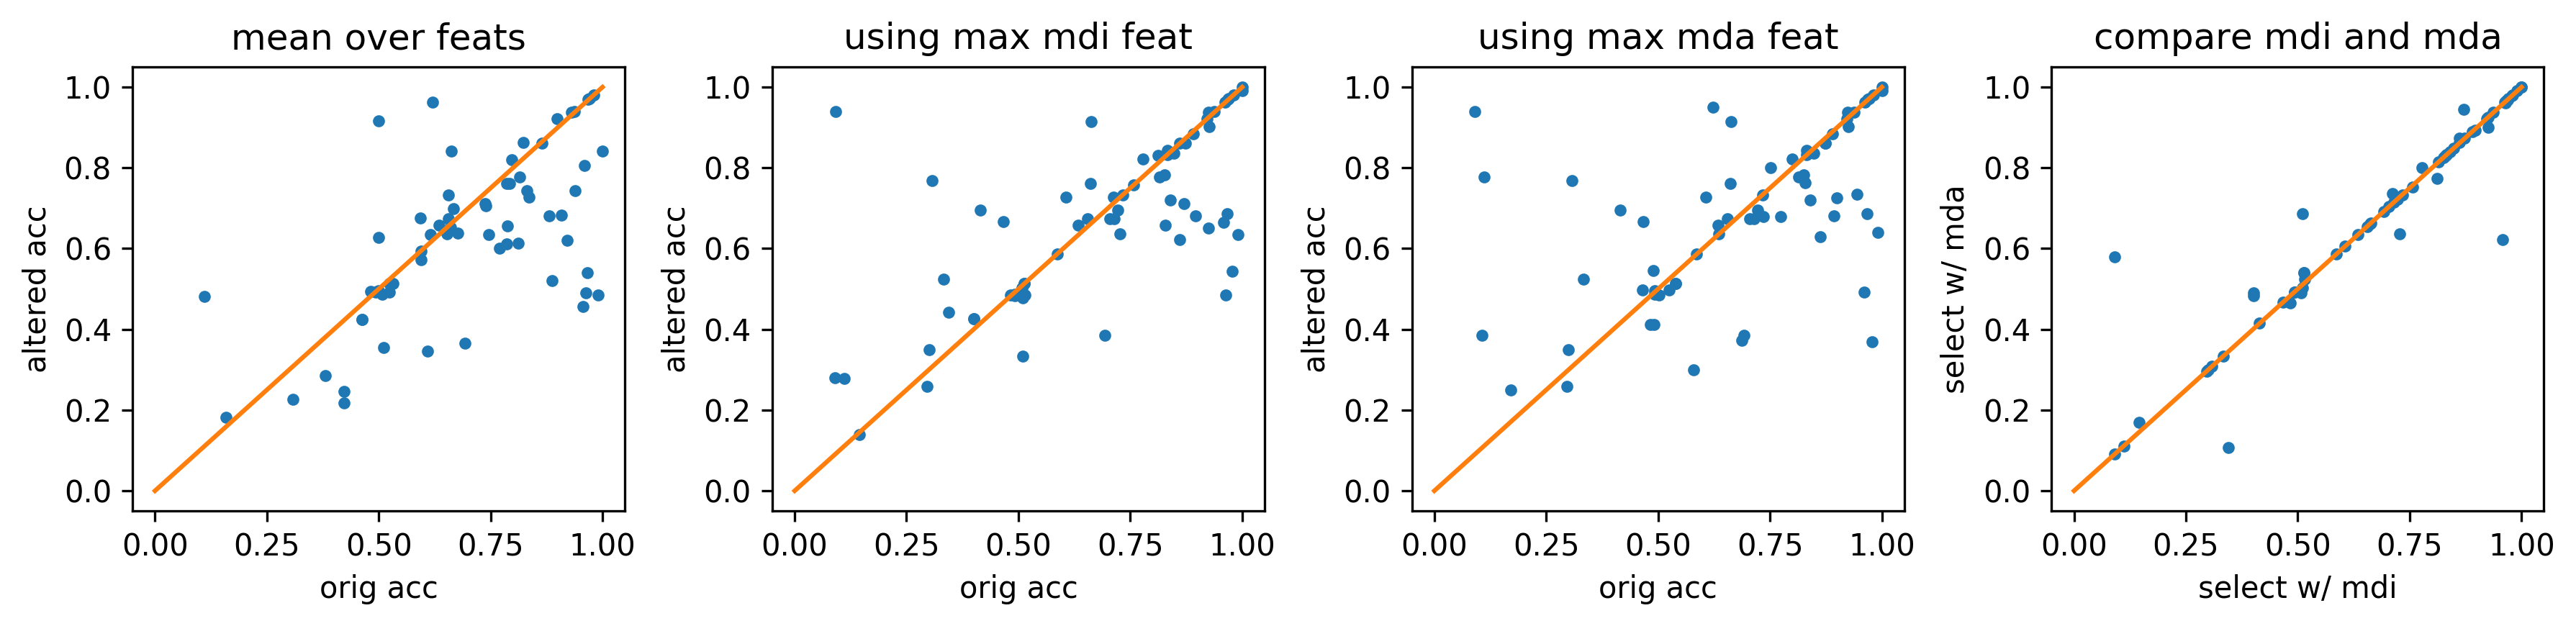

In [7]:
# note - these are, all, in fact binary classification
R, C, = 1, 4
plt.figure(figsize=(C * 3, R * 3), dpi=300) #, dpi=300)

plt.subplot(R, C, 1)
plt.title('mean over feats')
plt.plot(orig_mean, alt_mean, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('orig acc')
plt.ylabel('altered acc')

plt.subplot(R, C, 2)
plt.title('using max mdi feat')
plt.plot(orig_top, alt_top, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('orig acc')
plt.ylabel('altered acc')

plt.subplot(R, C, 3)
plt.title('using max mda feat')
plt.plot(orig_top_mda, alt_top_mda, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('orig acc')
plt.ylabel('altered acc')

plt.subplot(R, C, 4)
plt.title('compare mdi and mda')
plt.plot(orig_top, orig_top_mda, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('select w/ mdi')
plt.ylabel('select w/ mda')

plt.tight_layout()
plt.show()

# what went wrong

In [11]:
dset_names = full_results.dset_name
worst_idxs = np.argsort(alt_top - orig_top)
best_idxs = np.argsort(alt_top - orig_top)[::-1]

In [12]:
print('---------------WORST----------------')
for i in range(3):
    print(f'{dset_names[worst_idxs][i]} alt acc: {alt_top[worst_idxs][i]: 0.3f} orig acc {orig_top[worst_idxs][i]:0.3f}')

print('---------------BEST----------------')
for i in range(10):    
    print(f'{dset_names[best_idxs][i]} alt acc: {alt_top[best_idxs][i]: 0.3f} orig acc {orig_top[best_idxs][i]:0.3f}')

---------------WORST----------------
GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1 alt acc:  0.485 orig acc 0.964
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1 alt acc:  0.543 orig acc 0.978
GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1 alt acc:  0.635 orig acc 0.991
---------------BEST----------------
GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1 alt acc:  0.939 orig acc 0.091
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1 alt acc:  0.769 orig acc 0.308
GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1 alt acc:  0.695 orig acc 0.415
GAMETES_Epistasis_3-Way_20atts_0.2H_EDM-1_1 alt acc:  0.914 orig acc 0.663
GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM-2_001 alt acc:  0.667 orig acc 0.467
GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM-2_001 alt acc:  0.524 orig acc 0.333
Hill_Valley_with_noise alt acc:  0.280 orig acc 0.090
Hill_Valley_without_noise alt acc:  0.278 orig acc 0.111
adult alt acc:  0.727 orig acc 0.606
agaricus-lepiota alt acc:  0.760 orig acc 0.661


(60,)


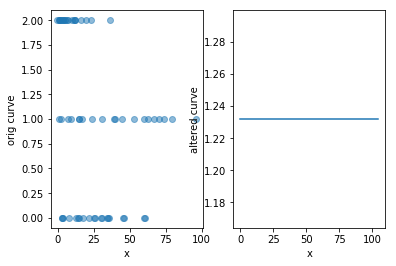

In [27]:
R, C = 1, 2

plt.subplot(R, C, 1)
# plt.plot(feat_vals, y, '.', alpha=0.5)
print(y.shape)
x = feat_vals.flatten()
jitter = np.random.randn(x.size) * 0.1
plt.plot(feat_vals.flatten() + jitter, y, 'o', alpha=0.5)

plt.xlabel('x')
plt.ylabel('orig curve')

plt.subplot(R, C, 2)
plt.plot(x_axis, scores_on_spaced_line)
plt.xlabel('x')
plt.ylabel('altered curve')
plt.show()